In [328]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import os

In [209]:
def resumen(datos):
    return print('Forma:\n', datos.shape,'\n\n',
                 'Columnas:\n', datos.columns,'\n\n',
                 'Tipos:\n', datos.dtypes,'\n\n',
                 'Datos nulos:\n', datos.isnull().sum(),'\n\n',
                 'Cabecera:\n', datos.head(10),'\n\n',
                 'Últimos datos:\n', datos.tail(10),'\n\n',
                 'Estadísticos:\n', datos.describe([0.05,0.25,0.5,0.75,0.95])
                )
def truncar(numero, decimales = 0):
    return np.trunc(numero*10**decimales)/(10**decimales)

In [302]:
def lineal(x, a, b):
    linea = a*x + b
    return linea

def lloyd_taylor(t, ref, e0):
    # Poner t en Celsius
    t0 = 261.5
    # e0 = 63
    resp = ref * np.exp(-e0/(t + 273.16 -t0))
    return resp
def respiracion_2(t, ref, e0):
    # Poner t en Kelvin    
    tref = 283.16
    resp = ref * np.exp(e0*(1-tref/t)*(1/tref*8.31))
    return resp
def Q10(t, ref, q10):
    # Poner t en Kelvin
    tref = 283.16
    resp = ref * q10**((t-tref)/10)
    return resp

def beta(b0, k, vpd, vpd0):
    if vpd > vpd0:
        beta = b0 * np.exp(-k*(vpd-vpd0))
    else:
        beta = b0
    return beta
def gpp(alfa, beta, rg):
    gpp = (alfa*beta*rg) / (alfa*rg + beta)
    return gpp
def nee(resp, gpp):
    nee = resp + gpp
    return nee

In [247]:
def coef_determinacion(observaciones, predicciones):
    residuo = observaciones - predicciones
    ss_res = np.sum(residuo**2)
    ss_tot = np.sum((observaciones - np.mean(observaciones))**2)
    r_cuadrado = 1 - (ss_res/ss_tot)
    return r_cuadrado
def regresion(modelo, x, y, pesos = None):
    # No puede haber nungún NaN
    ajuste, covarianzas = curve_fit(modelo, x, y, sigma = pesos)
    predicciones = modelo(x, *ajuste)
    errores = np.sqrt(np.diag(covarianzas))
    r_cuadrado = coef_determinacion(y, predicciones)
    residuo = y - predicciones
    return predicciones, ajuste, errores, r_cuadrado, residuo

In [214]:
def metadata(ejex, ejey):
    # plt.title(titulo, fontsize = 60, fontweight='bold')
    plt.xlabel(ejex, fontsize = 35)
    plt.ylabel(ejey, fontsize = 35)
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    return
def cifras_signif(i, cifras):
    texto = str('{:g}'.format(float('{:.{p}g}'.format(i, p = cifras))))
    return texto
def grafico_modelo(x, y, predicciones, ajuste,
                   errores, r_cuad, nombres,
                   j = 3
                  ):
    etiqueta = ''
    iterador = list(range(len(nombres)))
    for i in iterador:
        valor = cifras_signif(ajuste[i], j)
        error = cifras_signif(errores[i], j)
        etiqueta = (etiqueta
                    + ' ' + nombres[i] + ' = ' + valor
                    + '; std ' + nombres[i] + ' = ' + error
                    + '\n')
    etiqueta = etiqueta + ' R^2 = ' + cifras_signif(r_cuad, j)
    plt.plot(x, y, 'bo', markersize = 2)
    plt.plot(x, predicciones, 'r-',
             label = etiqueta
             )
    plt.legend(fontsize = 20)
    return
def grafico_residuos(x, res):
    plt.plot(x, res, 'bo', markersize = 2)
    plt.axhline(0, color = 'black', linestyle = '--')
    return

In [303]:
def regresion_y_grafico(modelo, x, y, xlabel,
                        ylabel, nombres, pesos = None):
    predicciones, ajuste, errores, r_cuadrado, res = regresion(modelo,
                                                               x, y,
                                                               pesos)
    plt.subplot(221)
    grafico_modelo(x, y, predicciones, ajuste,
                   errores, r_cuadrado, nombres
                  )
    metadata(xlabel, ylabel)
    plt.subplot(222)
    grafico_residuos(x, res)
    metadata(xlabel, ylabel)
    return ajuste, r_cuadrado, errores
def identidad(metodo, ajuste, validacion_x, validacion_y, lab, nombres):
    iterador = list(validacion_x.index)
    pred = list(range(len(validacion_x)))
    for i in iterador:
        j = iterador.index(i)
        pred[j] = metodo(validacion_x[i], ajuste[0], ajuste[1])
    recta, ajuste, errores, r_cuadrado, res = regresion(lineal,
                                                        validacion_y,
                                                        pred
                                                       )
    plt.subplot(223)
    grafico_modelo(validacion_y, pred, recta,
                   ajuste, errores, r_cuadrado,
                   nombres
                  )
    metadata(lab + ' Obs', lab + ' Pred')
    extremos = [validacion_y.min(), validacion_y.max()]
    plt.plot(extremos, extremos, 'g--')
    return pred, r_cuadrado, ajuste, errores

In [216]:
def mbe(x, y):
    n = x.count()
    diff = y - x
    mbe = diff.sum() * (1/n)
    return mbe
def mae(x, y):
    n = x.count()
    diff = abs(y - x)
    mae = diff.sum() * (1/n)
    return mae
def mse(x, y):
    n = x.count()
    diff = (y - x)**2
    mse = diff.sum() * (1/n)
    return mse
def rmse(x, y):
    rmse = (mse(x, y))**(1/2)
    return rmse
def indice_acuerdo(x, y):
    diff = (y - x)**2
    long = (np.abs(x) + np.abs(y))**2
    d = 1 - diff.sum()/long.sum()
    return d
def tabla_metricas(nombres = []):
    cols = ['MBE','MAE', 'MSE', 'RMSE',
            'R2_aj', 'R2_val', 'Acuerdo',
            'a val', 'std a val', 'b val',
            'std b val', 'n_aj', 'n_val'
           ]
    cols = cols + nombres
    iterador = list(range(len(nombres)))
    for i in iterador:
        nombres[i] = 'std ' + nombres[i]
    cols = cols + nombres
    num = len(cols)
    datos = np.zeros((1, num))
    tabla = pd.DataFrame(data = datos, columns = cols)
    return tabla
def metricas(x, y, tabla, j = 3):
    mbe_f = cifras_signif(mbe(x, y), j)
    mae_f = cifras_signif(mae(x, y), j)
    mse_f = cifras_signif(mse(x, y), j)
    rmse_f = cifras_signif(rmse(x, y), j)
    indice_f = cifras_signif(indice_acuerdo(x, y), j)
    tabla['MBE'][0] = mbe_f
    tabla['MAE'][0] = mae_f
    tabla['MSE'][0] = mse_f
    tabla['RMSE'][0] = rmse_f
    tabla['Acuerdo'][0] = indice_f
    return tabla
def grafico_metricas(tabla, lab):
    ax1 = plt.subplot(224)
    ax1.bar(tabla.columns[:4],
            tabla[tabla.columns[:4]].iloc[0],
            color = 'red'
            )
    metadata('', lab)
    ax2 = ax1.twinx()
    metr = list(tabla[tabla.columns[4:7]].iloc[0].values)
    ceros = [0, 0, 0, 0]
    lista = ceros + metr
    ax2.bar(tabla.columns[:7],
            lista,
            color = 'blue',
           )
    ax2.set_ylim(0, 1)
    metadata('', '')
    return

In [249]:
def analisis(metodo, x, y, validacion_x, validacion_y,
             xlab, ylab, nombres, tabla, pesos = None
            ):
    grafico = plt.figure(figsize = (36, 18)).subplots(2, 2)
    ajuste, r_ajuste, std_ajuste = regresion_y_grafico(metodo, x, y,
                                                       xlab, ylab,
                                                       nombres,
                                                       pesos
                                                       )
    pred, r_validac, recta, std_recta = identidad(metodo, ajuste,
                                                  validacion_x,
                                                  validacion_y,
                                                  ylab, ['a', 'b']
                                                  )
    tabla['R2_aj'][0] = r_ajuste
    tabla['R2_val'][0] = r_validac
    resultados = metricas(validacion_y, pred, tabla)
    grafico_metricas(resultados, ylab)
    resultados['n_aj'][0] = x.count() 
    resultados['n_val'][0] = validacion_x.count()
    iterador = list(range(len(nombres)))
    for i in iterador:
        resultados[nombres[i]][0] = ajuste[i]
        resultados['std ' + nombres[i]][0] = std_ajuste[i]
    resultados['a val'][0] = recta[0]
    resultados['std a val'][0] = std_recta[0]
    resultados['b val'][0] = recta[1]
    resultados['std b val'][0] = std_recta[1]
    return grafico, resultados

In [218]:
datos = pd.read_csv(
    'C:\\Users\\nahue\\Desktop\\Tesis_2\\Datos\\Completos_buenos.txt',
    #'C:\\Users\\BIOMET\\Desktop\\Tesis_2\\Datos\\Completos_buenos.txt',
    delimiter = '\t',
    decimal = '.',
    na_values = -9999,
    skiprows = [1],
    encoding = 'ascii'
    )

In [219]:
resumen(datos)

Forma:
 (14442, 37) 

 Columnas:
 Index(['Year', 'DoY', 'Hour', 'NEE', 'LE', 'H', 'Rg', 'Tair', 'Tsoil', 'rH',
       'VPD', 'Ustar', 'TS1', 'TS2', 'TS3', 'TS4', 'U', 'DIR', 'PP', 'QG1',
       'QG2', 'WET', 'PAR', 'TSH1', 'HS1', 'GH1', 'TSH2', 'HS2', 'GH2', 'TSH3',
       'HS3', 'GH3', 'TSH4', 'HS4', 'GH4', '   r_err_co2[%]',
       '   noise_co2[%]'],
      dtype='object') 

 Tipos:
 Year               float64
DoY                float64
Hour               float64
NEE                float64
LE                 float64
H                  float64
Rg                 float64
Tair               float64
Tsoil              float64
rH                 float64
VPD                float64
Ustar              float64
TS1                float64
TS2                float64
TS3                float64
TS4                float64
U                  float64
DIR                float64
PP                 float64
QG1                float64
QG2                float64
WET                float64
PAR              

In [11]:
dias = np.array([0, 16, 46, 76,
                107, 137, 168, 199,
                229, 260, 290, 303
                ])
lista = list(range(1, len(dias)))
promedio = list(range(1, len(dias)))
for i in lista:
    desde = dias[i-1] * 48
    hasta = dias[i] * 48
    promedio[i-1] = datos['Tair'][desde:hasta].mean()
print(promedio)

[20.153313802083336, 17.015215277777788, 16.98765277777783, 10.506136724960305, 7.781109929078067, 8.458080736543934, 10.250757575757623, 13.119559027777756, 14.593571908602158, 17.034160839160883, 21.359814814814897]


In [12]:
datos['Tair'].mean()

13.521831034482787

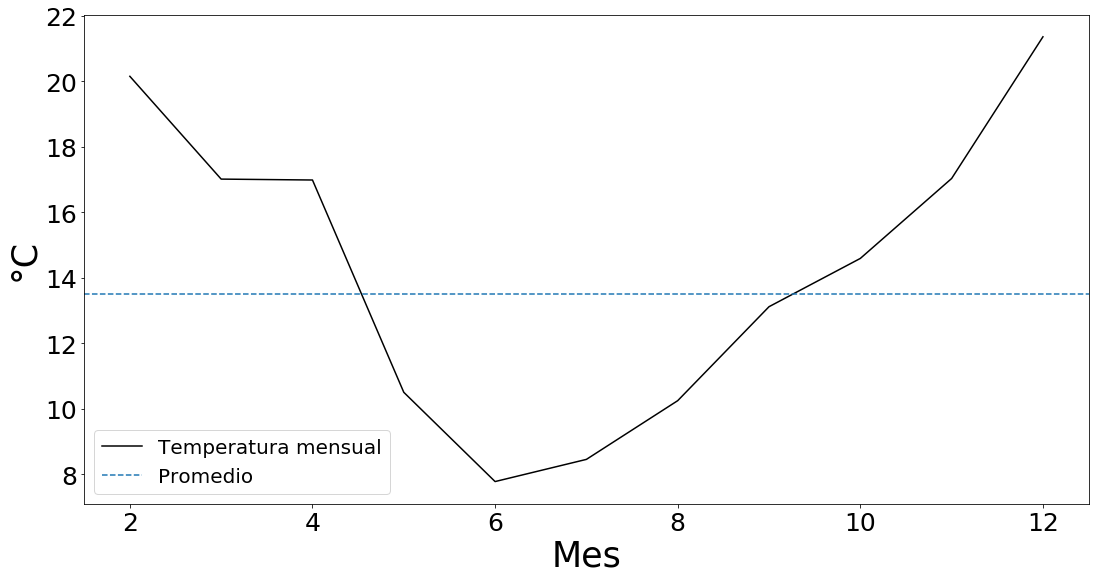

In [13]:
x = list(range(2, 13))
plt.figure(figsize = (18, 9))
plt.plot(x, promedio, color = 'black')
metadata('Mes', '°C')
plt.axhline(datos['Tair'].mean(), ls = '--')
plt.legend(['Temperatura mensual', 'Promedio'], fontsize= 20)

In [220]:
datos_validos = datos[(datos['Rg'] < 5)
                      & (datos['Ustar'] > 0.14167)
                      & pd.notna(datos['Tair'])
                      & (datos['NEE'] >= 0)
                     ]
datos_validos.describe()

,Year,DoY,Hour,NEE,LE,H,Rg,Tair,Tsoil,rH,...,HS2,GH2,TSH3,HS3,GH3,TSH4,HS4,GH4,r_err_co2[%],noise_co2[%]
count,2171.0,2171.000000,2171.000000,2171.000000,2112.000000,2170.000000,2.171000e+03,2171.000000,2171.000000,2171.000000,...,2171.000000,2171.000000,2070.000000,2070.000000,2070.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000
mean,2018.0,247.984339,11.026716,1.696985,7.752176,-32.870873,1.599102e-01,11.337589,11.569908,80.331713,...,1.319714,0.186026,12.899940,0.536464,0.208965,12.555299,0.406413,0.288375,15.045284,1.193923
std,0.0,63.345216,9.099044,1.432462,20.188574,17.050212,6.085620e-01,4.460148,3.517135,9.493835,...,0.301480,0.043465,3.501901,0.030801,0.026402,3.077834,0.035106,0.041592,16.323177,1.859846
min,2018.0,91.000000,0.000000,0.000450,-205.078369,-138.818542,1.808498e-12,-1.005000,4.187500,29.065000,...,0.347000,0.067000,5.830000,0.447000,0.148000,7.330000,0.219500,0.111000,5.653092,0.135974
25%,2018.0,208.000000,3.000000,0.707425,-4.021991,-43.011824,2.000000e-02,8.585000,8.555000,75.117500,...,1.354250,0.157000,9.766250,0.540500,0.186625,9.800000,0.390500,0.272500,9.744890,0.580057
50%,2018.0,255.000000,6.000000,1.330000,4.443480,-30.677891,2.500000e-02,10.975000,11.272500,82.150000,...,1.447000,0.181000,12.600000,0.547250,0.208500,12.300000,0.410000,0.294000,11.204628,0.744245
75%,2018.0,298.000000,21.000000,2.262975,15.096420,-20.857051,3.000000e-02,13.935000,14.218750,87.800000,...,1.483250,0.222500,15.788750,0.552500,0.227000,15.200000,0.430000,0.315000,14.113116,1.072424
max,2018.0,346.000000,23.500000,14.427700,163.791779,16.905794,4.795000e+00,28.455000,21.315000,94.500000,...,1.644000,0.286000,21.570000,0.572500,0.265000,18.265000,0.478000,0.349000,299.992065,39.960625


In [274]:
def todo(predictora, modelo):
    # camino = 'C:\\Users\\BIOMET\\Desktop\\Tesis_2\\Modelos\\'
    camino = 'C:\\Users\\nahue\\Desktop\\Tesis_2\\Modelos\\MAD\\'
    guardado = camino + '\\' + 'T0 = 261.5 y E0 = 46.5' + '\\' + predictora + '\\'
    if not os.path.exists(guardado):
        os.makedirs(guardado)
    muestra_tot = datos_validos.sample(frac = 4/5, random_state = 1).sort_values(predictora)
    validacion_tot = datos_validos.drop(muestra_tot.index)
    tair_mod_1_tot, para_analisis = analisis(modelo[0],
                                             muestra_tot[predictora],
                                             muestra_tot['NEE'],
                                             validacion_tot[predictora],
                                             validacion_tot['NEE'],
                                             '°C', 'micromol/(m^2 s)',
                                             modelo[1:], tabla_metricas(modelo[1:]),
                                            )
    titulo = 'Desde 0 Hasta 360'
    para_analisis['Desde'] = muestra_tot['DoY'].min()
    para_analisis['Hasta'] = muestra_tot['DoY'].max()
    plt.savefig(guardado + titulo +'.png')
    dias = np.arange(60, 420, 60)
    iterador = list(range(1, len(dias)))
    for i in iterador:
        desde = dias[i-1]
        hasta = dias[i]
        muestra_vent = muestra_tot[(muestra_tot['DoY'] > desde)
                               & (muestra_tot['DoY'] < hasta)
                               ]
        validacion_vent = validacion_tot[(validacion_tot['DoY'] > desde)
                                         & (validacion_tot['DoY'] < hasta)
                                         ]
        cant_mu = muestra_vent['NEE'].notnull().sum()
        cant_va = validacion_vent['NEE'].notnull().sum()
        if cant_mu > 9 and cant_va > 2:
            titulo = 'Desde ' + str(desde) + ' Hasta ' + str(hasta)
            tair_mod_1_ven, error_vent = analisis(modelo[0],
                                                  muestra_vent[predictora],
                                                  muestra_vent['NEE'],
                                                  validacion_vent[predictora],
                                                  validacion_vent['NEE'],
                                                  '°C', 'micromol/(m^2 s)',
                                                  modelo[1:], tabla_metricas(modelo[1:]),
                                                 )
            plt.savefig(guardado + titulo +'.png')
            plt.close()
            error_vent['Desde'] = muestra_vent['DoY'].min()
            error_vent['Hasta'] = muestra_vent['DoY'].max()
            para_analisis = para_analisis.append(error_vent, ignore_index = True)
    dias = np.arange(90, 355, 5)
    iterador = list(range(3, len(dias)))
    for i in iterador:
        desde = dias[i-3]
        hasta = dias[i]
        muestra_vent = muestra_tot[(muestra_tot['DoY'] > desde)
                               & (muestra_tot['DoY'] < hasta)
                               ]
        validacion_vent = validacion_tot[(validacion_tot['DoY'] > desde)
                                         & (validacion_tot['DoY'] < hasta)
                                         ]
        cant_mu = muestra_vent['NEE'].notnull().sum()
        cant_va = validacion_vent['NEE'].notnull().sum()
        if cant_mu > 10 and cant_va > 5:
            titulo = 'Desde ' + str(desde) + ' Hasta ' + str(hasta)
            tair_mod_1_ven, error_vent = analisis(modelo[0],
                                                  muestra_vent[predictora],
                                                  muestra_vent['NEE'],
                                                  validacion_vent[predictora],
                                                  validacion_vent['NEE'],
                                                  '°C', 'micromol/(m^2 s)',
                                                  modelo[1:], tabla_metricas(modelo[1:]),
                                                 )
            plt.savefig(guardado + titulo +'.png')
            plt.close()
            error_vent['Desde'] = muestra_vent['DoY'].min()
            error_vent['Hasta'] = muestra_vent['DoY'].max()
            para_analisis = para_analisis.append(error_vent, ignore_index = True)
    para_analisis.to_csv(guardado + '\\Resultados.csv',
                         sep = '\t',
                         na_rep = -9999,
                         index = False,
                         encoding = 'ascii'
                         )
    print(predictora + 'Listo!')
    return

TypeError: leastsq() got multiple values for keyword argument 'loss'

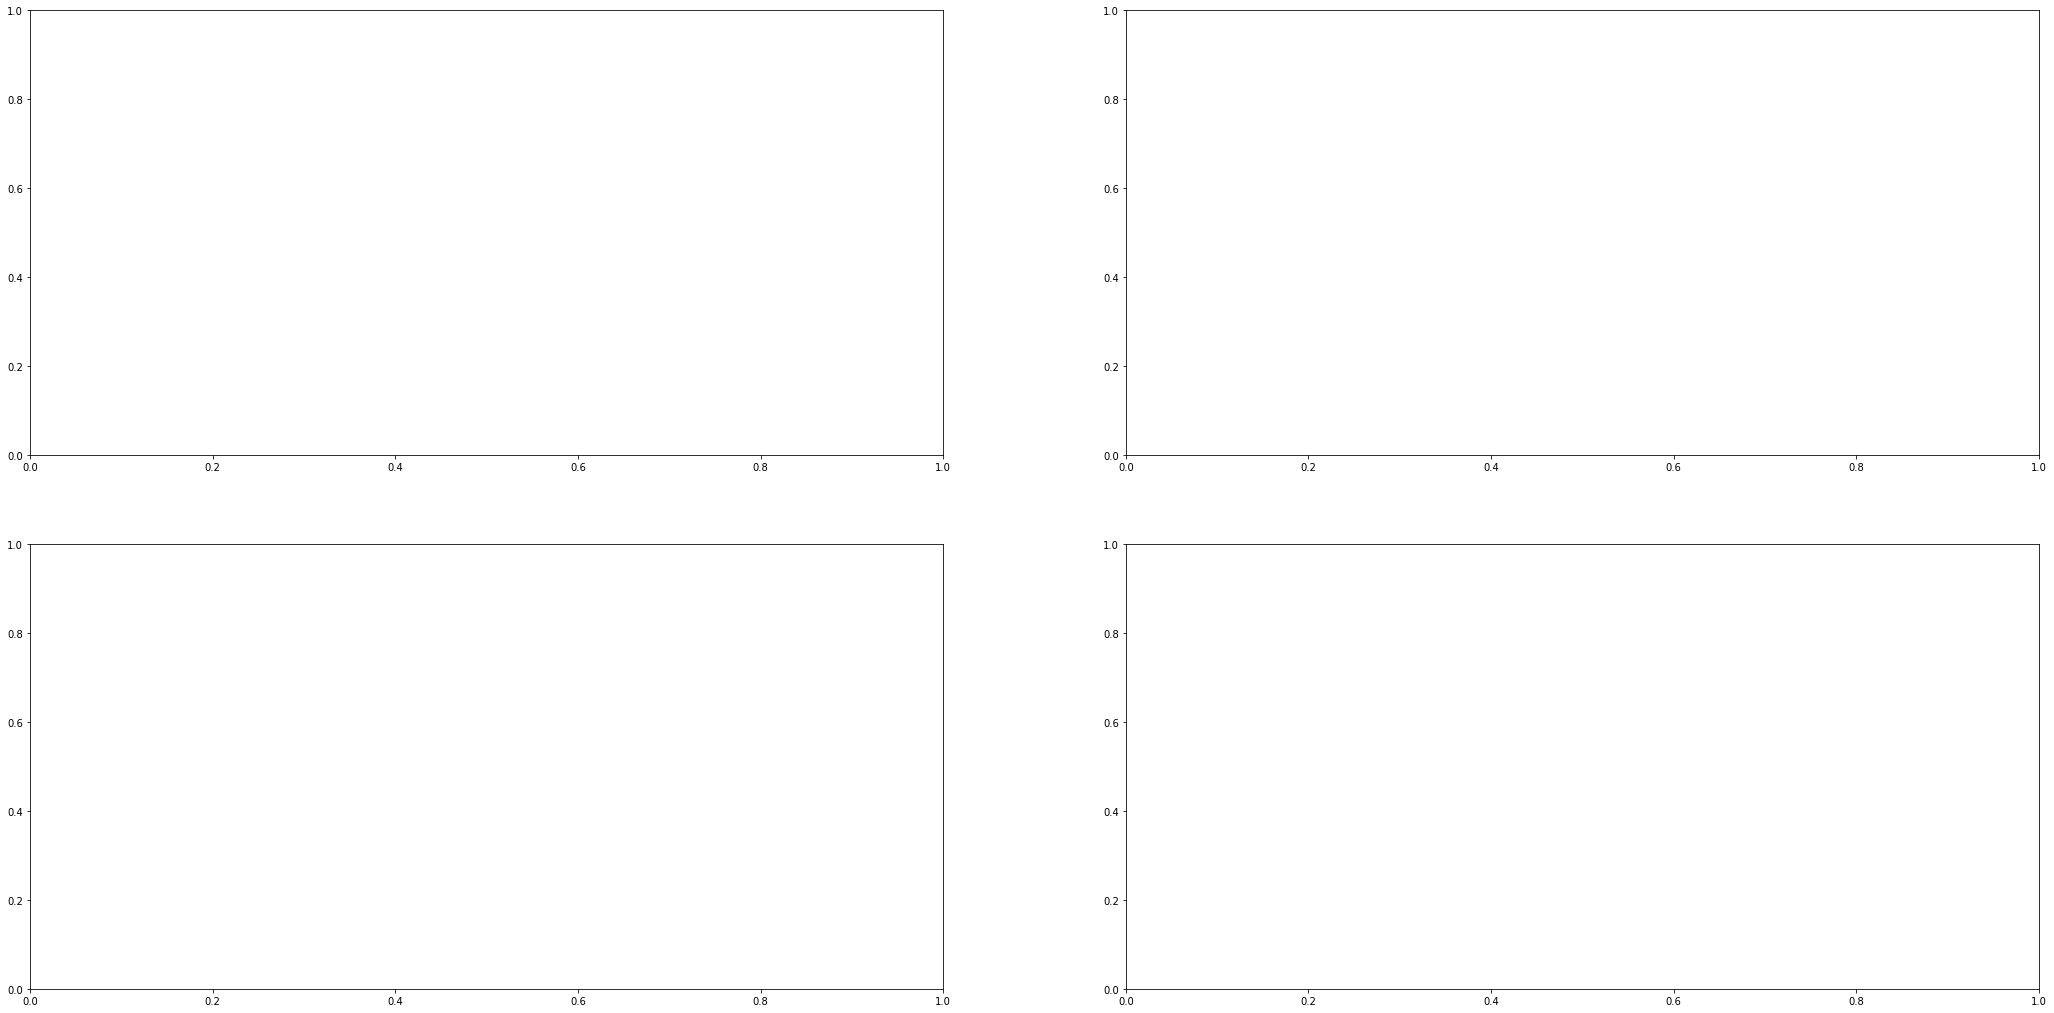

In [19]:
modelo = [lloyd_taylor, 'Ref', 'E0']
predictora = ['Tair', 'Tsoil']
for i in predictora:
    todo(i, modelo, )

TS1Listo!
TS2Listo!


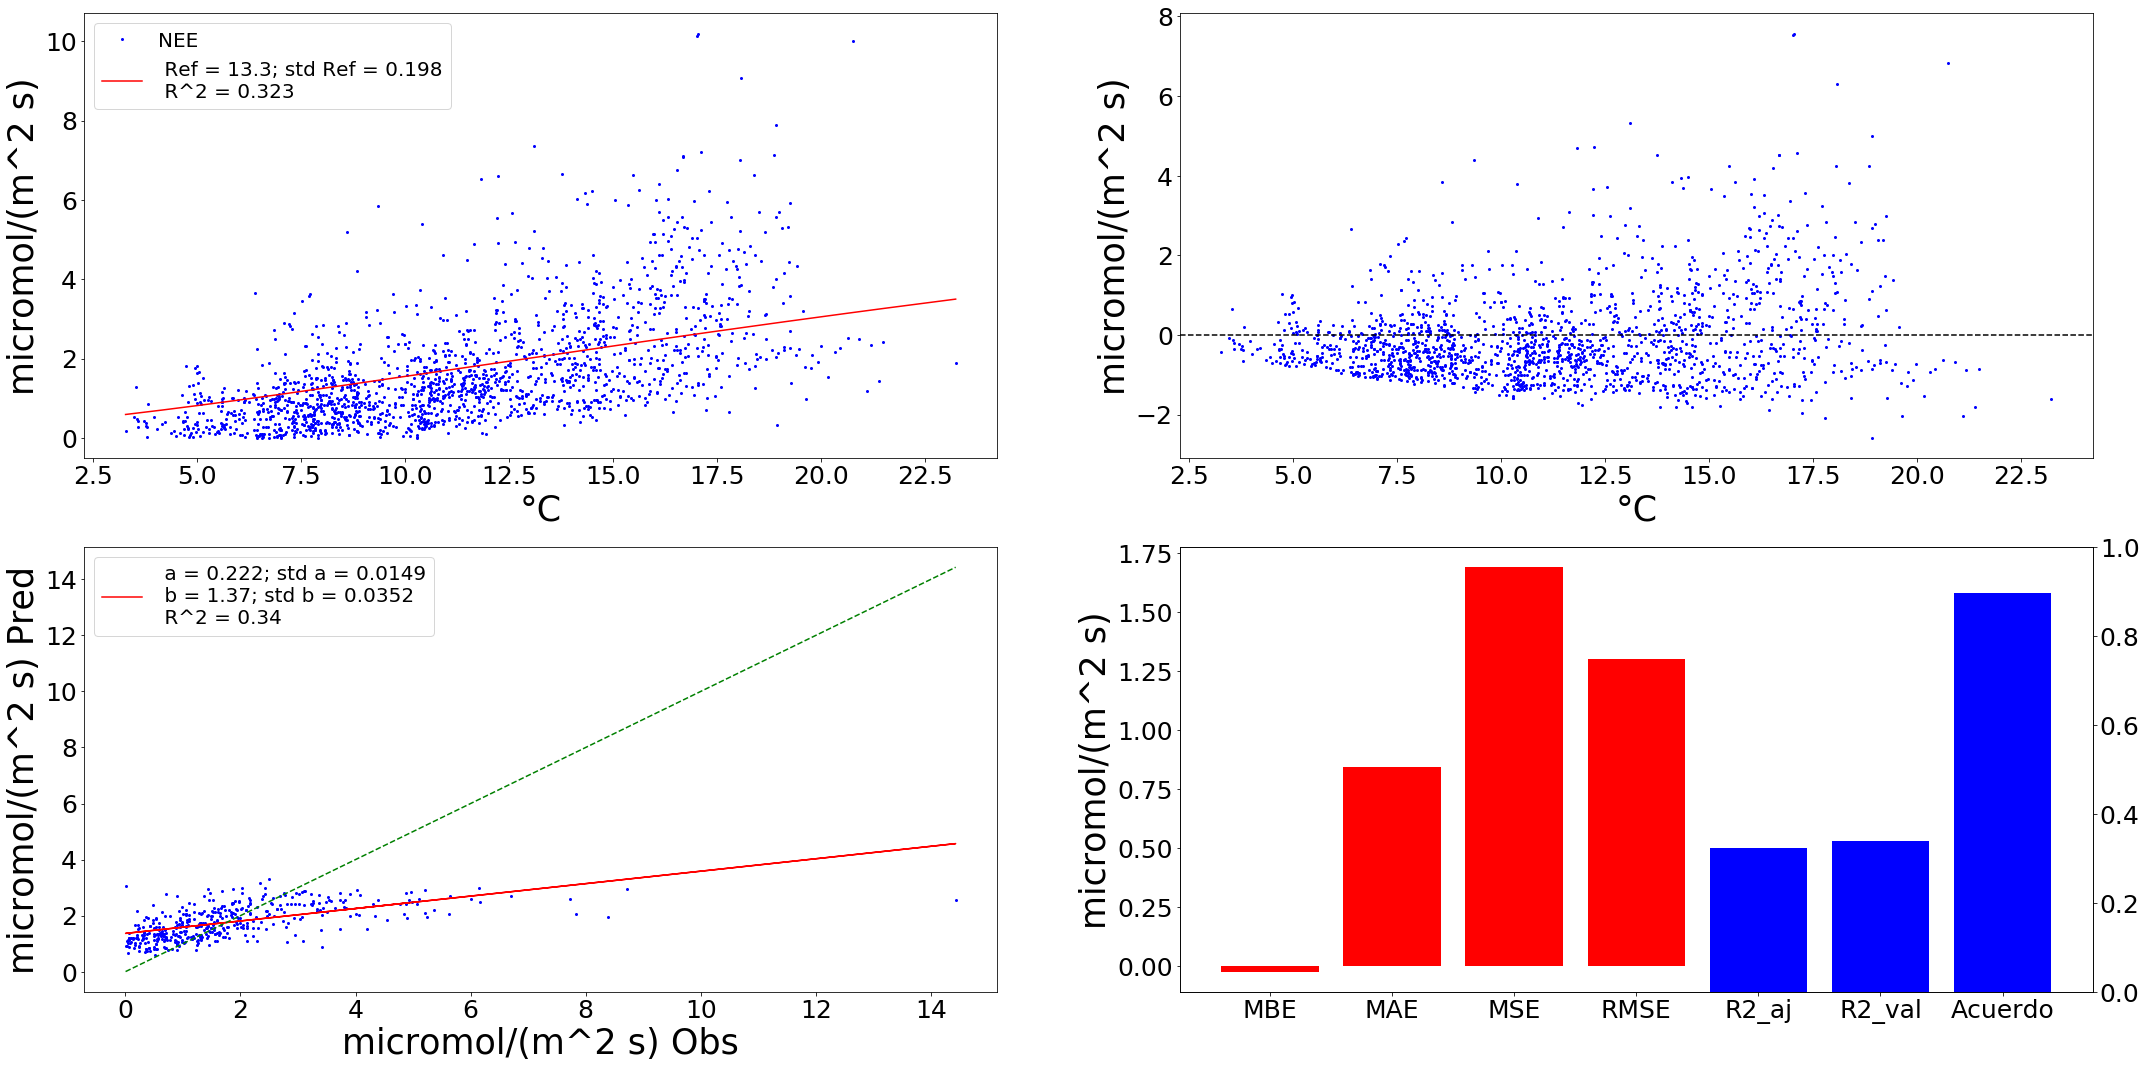

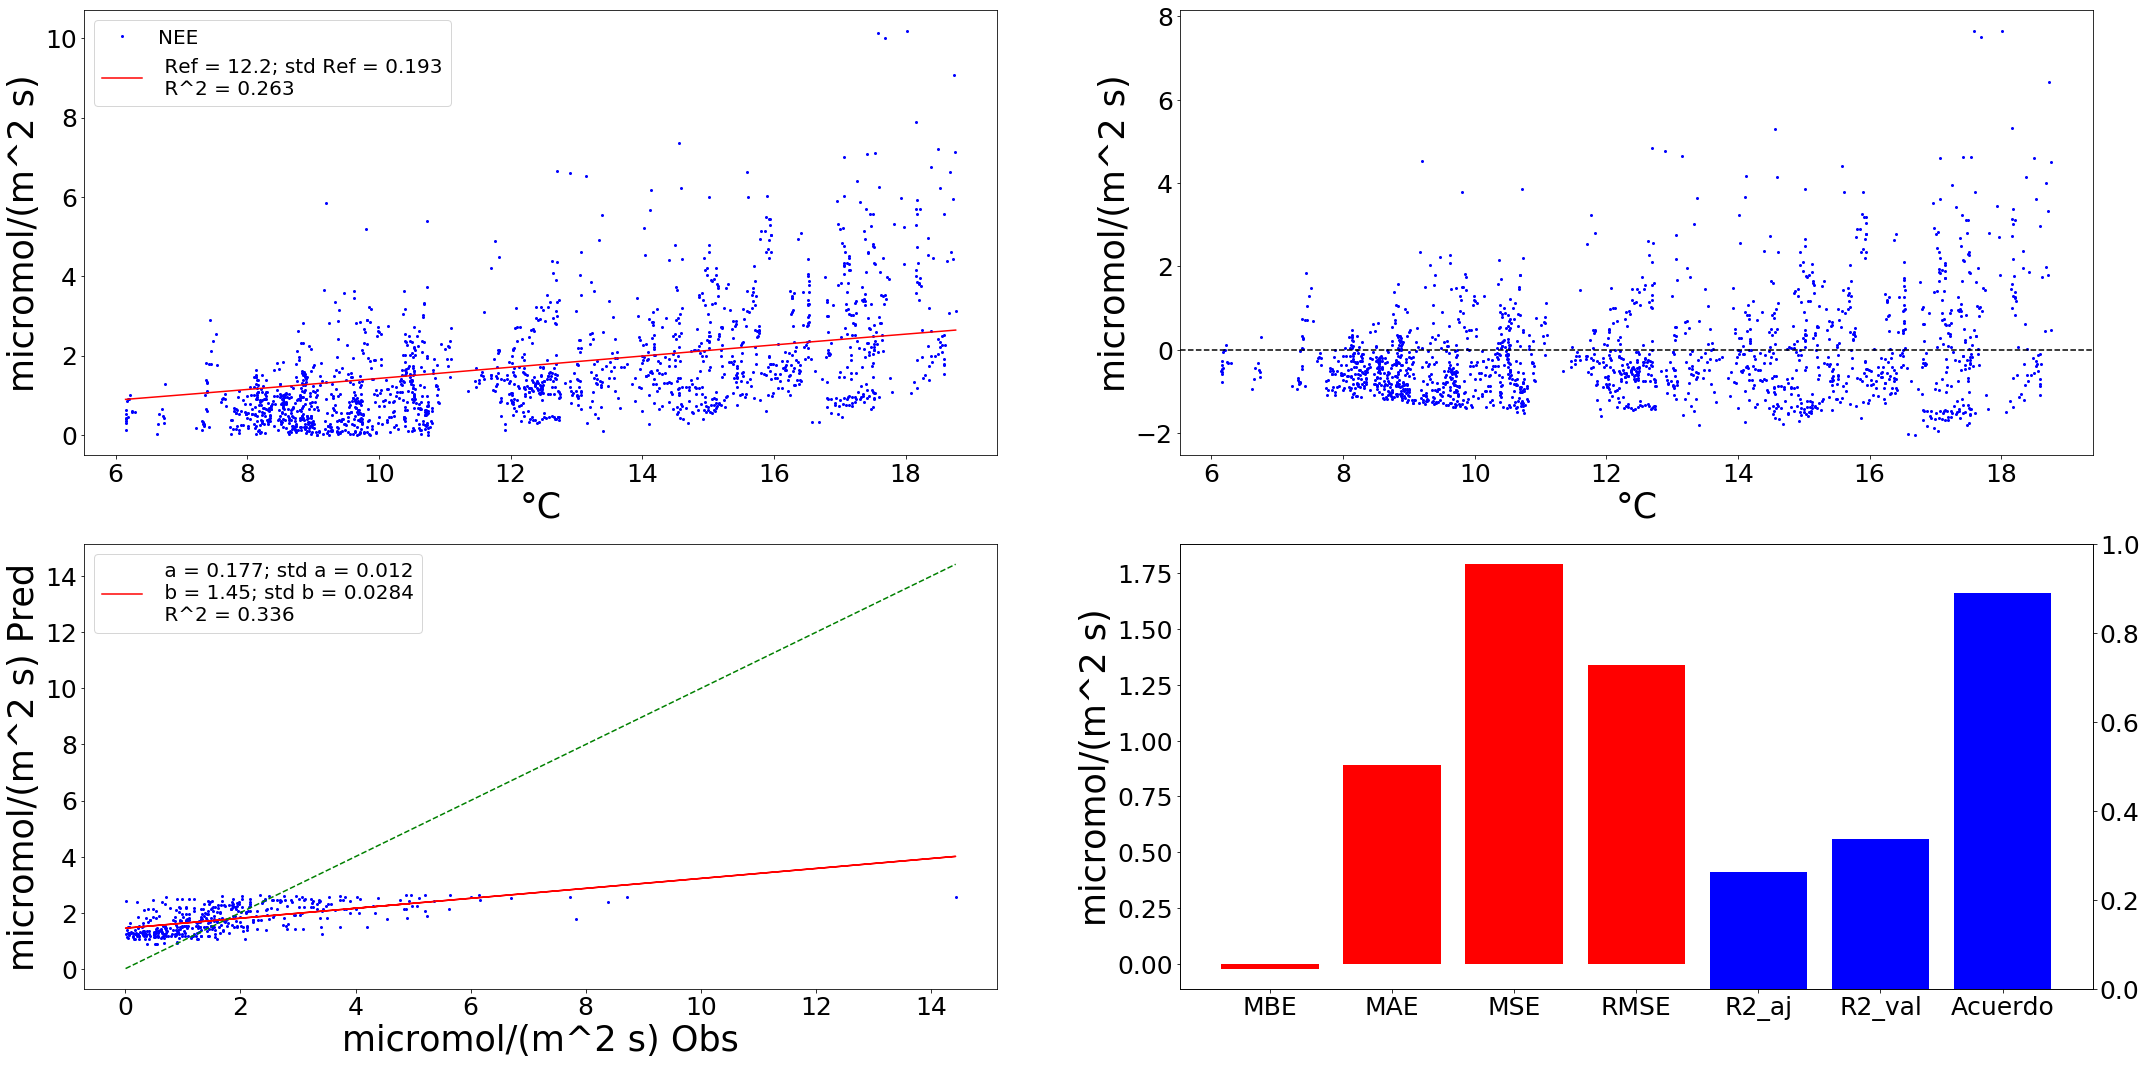

In [59]:
modelo = [lloyd_taylor, 'Ref']
predictora = ['TS1', 'TS2']
for i in predictora:
    todo(i, modelo)

In [363]:
datos_ordenados = datos_validos.sample(frac = 4/5, random_state = 1).sort_values('Tair')
X = datos_ordenados['Tair']
Y = datos_ordenados['NEE']
def lsq(x0, X, Y):
    return lloyd_taylor(X, x0[0], x0[1]) - Y
out_l1 = least_squares(lsq, x0=[20, 40], args=(X.values, Y.values), loss='soft_l1')
out_l1.x

array([22.72755487, 62.75446234])

In [366]:
def lsq(x0, X, Y):
    return lloyd_taylor(X, x0[0], x0[1]) - Y
out = least_squares(lsq, x0=[20, 40], args=(X.values, Y.values))
out.x

array([22.62741486, 60.56525534])

In [364]:
def lsq2(x0, X, Y):
    return np.sqrt(2*abs(lloyd_taylor(X, x0[0], x0[1]) - Y))
out_L1 = least_squares(lsq2, x0=[20, 40], args=(X.values, Y.values))
out_L1.x

array([21.89201906, 63.22185443])

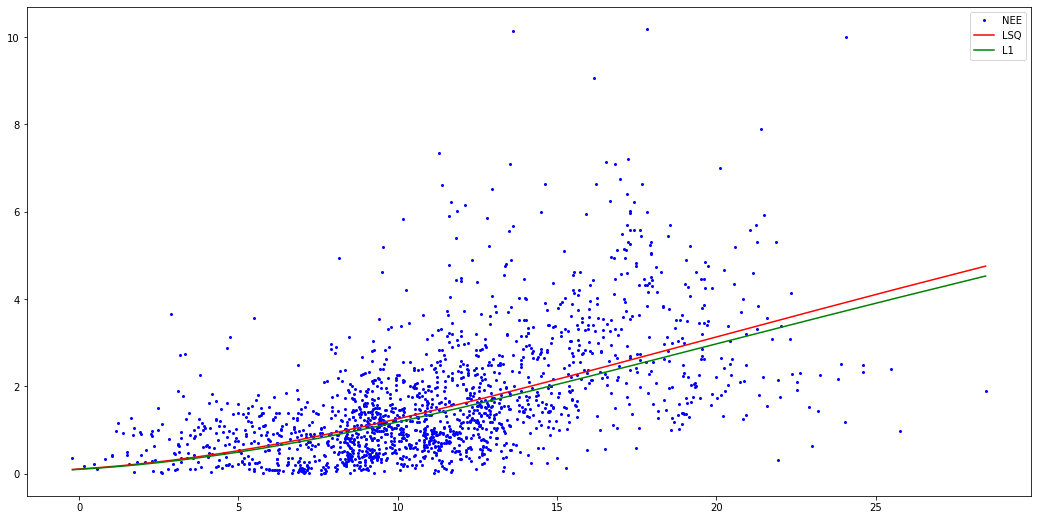

In [359]:
lsq1 = lloyd_taylor(X, 22.72, 62.75)
l1 = lloyd_taylor(X, 21.89, 63.22)
plt.figure(figsize=(18,9))
plt.plot(X, Y, 'bo', ms = 2)
plt.plot(X, lsq1, 'r-')
plt.plot(X, l1, 'g-')
plt.legend(['NEE', 'LSQ', 'L1'])

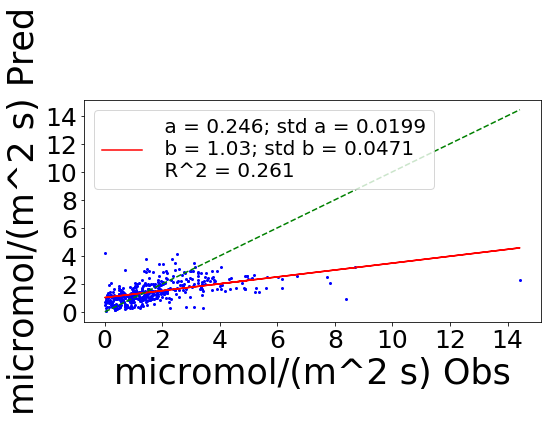

In [361]:
Xv = datos_validos.drop(datos_ordenados.index)
plt.figure(figsize=(18,9))
hola = identidad(lloyd_taylor, [21.89, 63.22], Xv['Tair'], Xv['NEE'], 'micromol/(m^2 s)', ['a', 'b'])

In [367]:
J = out.jac
cov = np.linalg.inv(J.T.dot(J))
var = np.sqrt(np.diagonal(cov))
var

array([1.7641642 , 2.01196897])

In [207]:
# Import packages.
import cvxpy as cp

# Generate data.
np.random.seed(1)
t = list(range(10, 50))
p = np.random.rand(40) / 100
y = np.exp(np.ones(40)/t)

# Define and solve the CVXPY problem.
ref = cp.Variable(1)
e0 = cp.Variable(1)
t0 = 0.9*np.ones(40)
#lloyd = ref * np.exp(-e0/(t + 273.16 -t0))
cost = cp.norm1((ref + e0*np.ones(40)/(t-t0) - cp.log(y))/p)
prob = cp.Problem(cp.Minimize(cost))
prob.solve()

# Print result.
print("\nThe optimal value is", prob.value)
print("The optimal Ref is")
print(np.exp(ref.value))
print("The optimal e0 is")
print(e0.value)
#print("The norm of the residual is ", cp.norm(x*a + b - y, p=2).value)


The optimal value is 8.514277094897077
The optimal Ref is
[1.00202908]
The optimal e0 is
[0.9025]


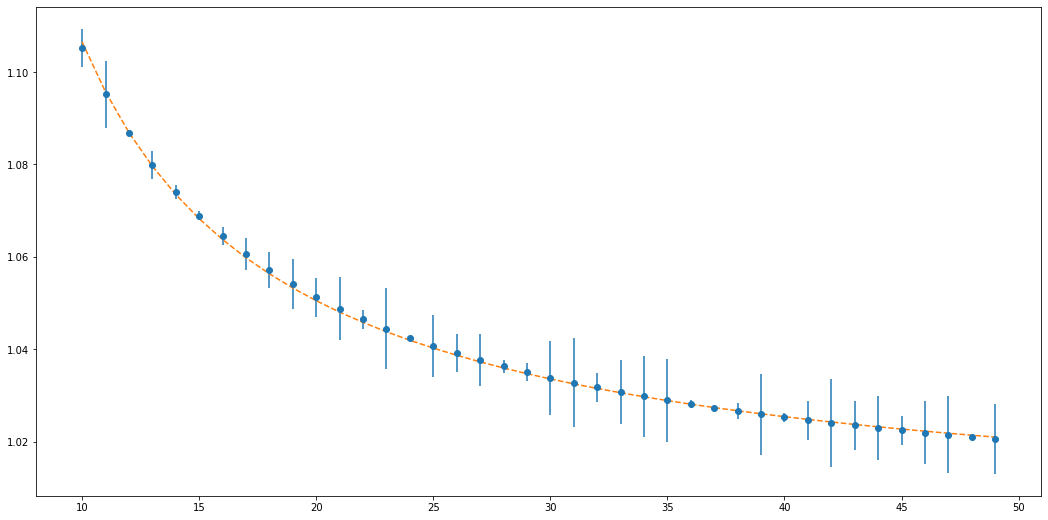

In [190]:
y_val = np.exp(ref.value)*np.exp(e0.value/(t-t0))
plt.figure(figsize=(18,9))
plt.errorbar(t, y, yerr = p, fmt = 'o')
plt.plot(t, y_val, ls='--')

In [299]:
datos_ordenados = datos_validos.sample(frac = 4/5, random_state = 1).sort_values('Tair')
X = datos_ordenados['Tair']
Y = datos_ordenados['NEE']
ref = cp.Variable(1)
e0 = cp.Variable(1)
t0 = 261.5
perdida = cp.sum_squares(ref - e0/(X+273.16-t0) - cp.log(Y))
prob = cp.Problem(cp.Minimize(perdida), [e0>=0, ref>=0, t0>=0])
prob.solve()
print("\nThe optimal value is", prob.value)
print("The optimal Ref is")
print(np.exp(ref.value))
print("The optimal e0 is")
print(e0.value)
print("The optimal t0 is")
print(t0.value)

DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
Promote(var7705, (1737,)) / ([272.95  273.325 273.64  ... 298.64  298.94  301.615] + -var7706)

In [293]:
cp.sum_squares(ref - e0/(np.array(X)+273.16-t0) - cp.log(Y)).is_dcp()

False

In [294]:
np.array(X)

array([-0.21 ,  0.165,  0.48 , ..., 25.48 , 25.78 , 28.455])

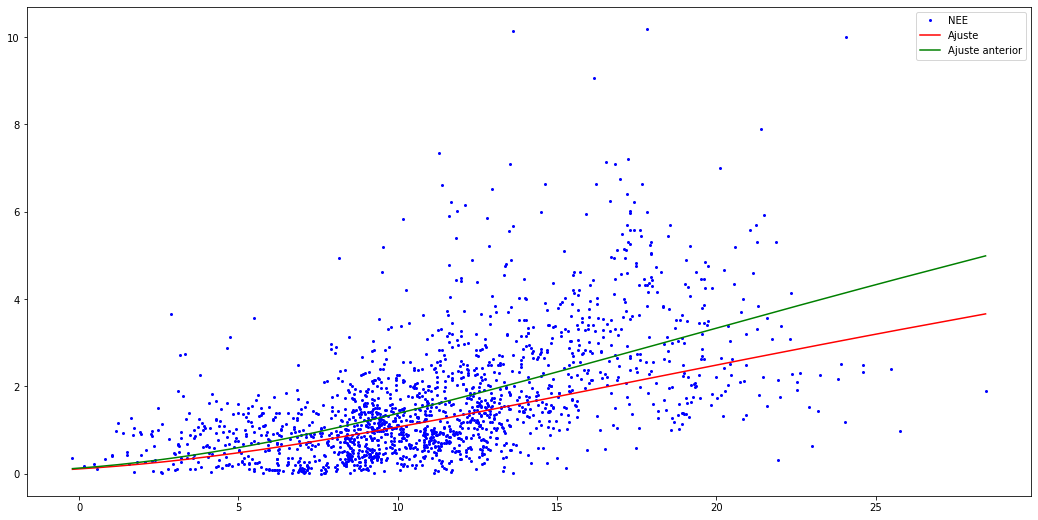

In [272]:
y_ajuste = np.exp(ref.value)*np.exp(-e0.value/(X+273.16-t0))
y_anterior = 22.6*np.exp(-60.6/(X+273.16-t0))
plt.figure(figsize=(18,9))
plt.plot(X, Y, 'bo', ms = 2)
plt.plot(X, y_ajuste, 'r-')
plt.plot(X, y_anterior, 'g-')
plt.legend(['NEE', 'Ajuste', 'Ajuste anterior'])

In [307]:
datos_validos['NEE'].tail(10)

13953     3.84355
13974     9.99570
13988     1.17720
13991     2.24315
13992     3.19395
13993     1.37095
14000    14.42770
14001     3.95405
14002     3.54725
14003     3.81205
Name: NEE, dtype: float64

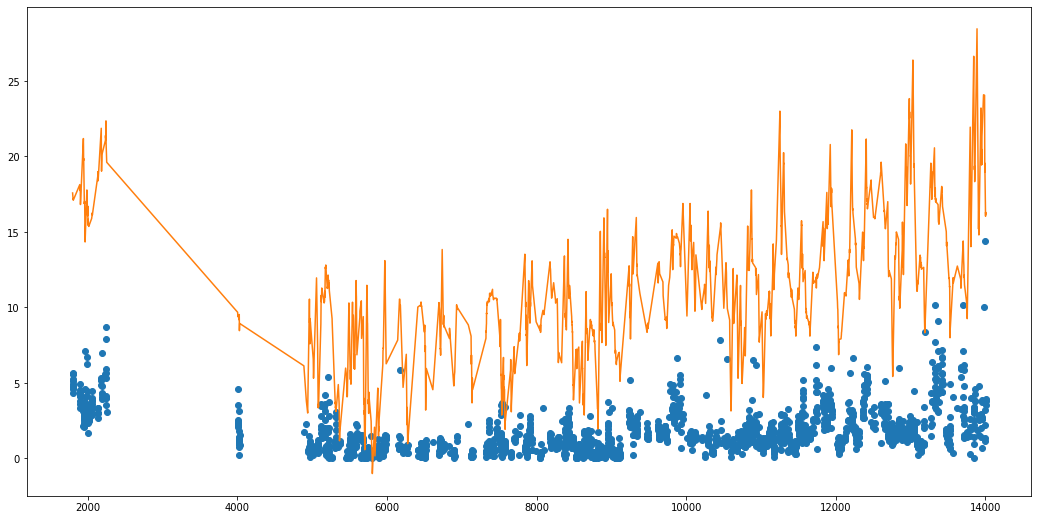

In [320]:
plt.figure(figsize=(18,9))
plt.plot(datos_validos['NEE'], 'o')
plt.plot(datos_validos['Tair'])

In [323]:
np.corrcoef(datos_validos['Tair'], datos_validos['NEE'])

array([[1.       , 0.5491761],
       [0.5491761, 1.       ]])

In [324]:
np.corrcoef(datos_validos['Tsoil'], datos_validos['NEE'])

array([[1.        , 0.60253743],
       [0.60253743, 1.        ]])

In [325]:
np.corrcoef(datos_validos['TS1'], datos_validos['NEE'])

array([[1.        , 0.59586021],
       [0.59586021, 1.        ]])

In [326]:
np.corrcoef(datos_validos['TS2'], datos_validos['NEE'])

array([[1.        , 0.56940303],
       [0.56940303, 1.        ]])

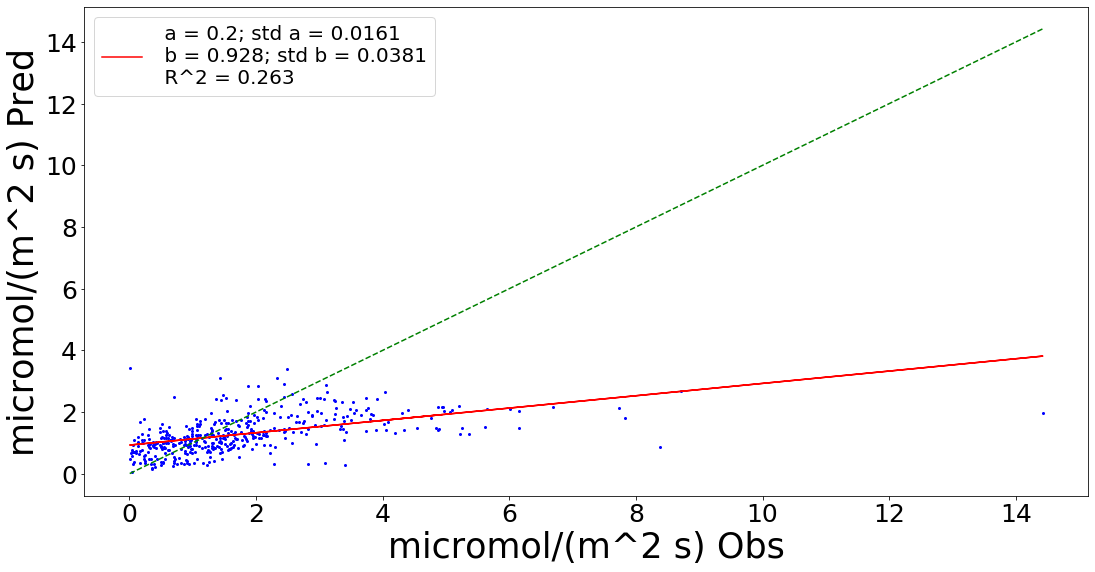

In [252]:
Xv = datos_validos.drop(datos_ordenados.index)
hola = identidad(lloyd_taylor, [15.56, 58.06], Xv['Tair'], Xv['NEE'], 'micromol/(m^2 s)', ['a', 'b'])

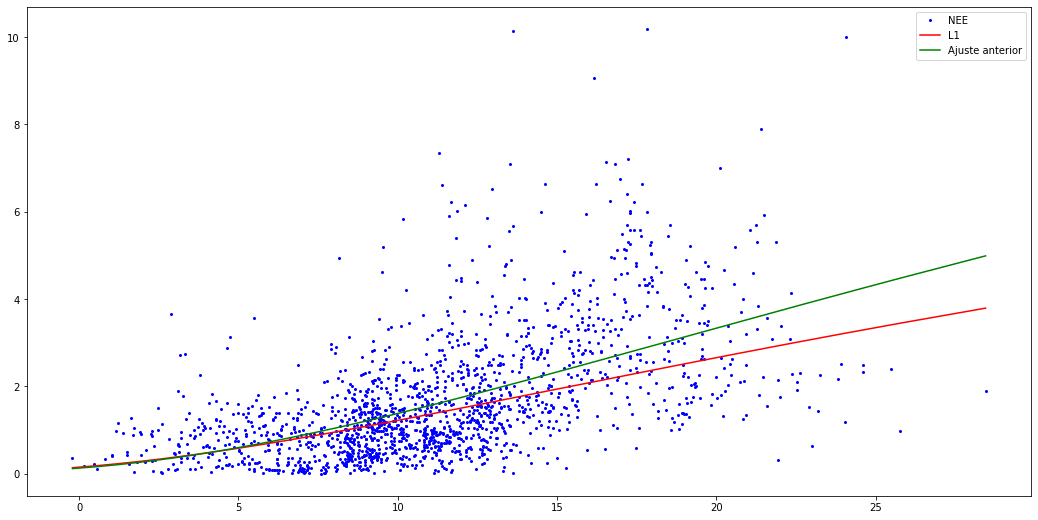

In [267]:
y_ajuste = np.exp(ref.value)*np.exp(-e0.value/(X+273.16-t0))
y_anterior = 22.6*np.exp(-60.6/(X+273.16-t0))
plt.figure(figsize=(18,9))
plt.plot(X, Y, 'bo', ms = 2)
plt.plot(X, y_ajuste, 'r-')
plt.plot(X, y_anterior, 'g-')
plt.legend(['NEE', 'L1', 'Ajuste anterior'])

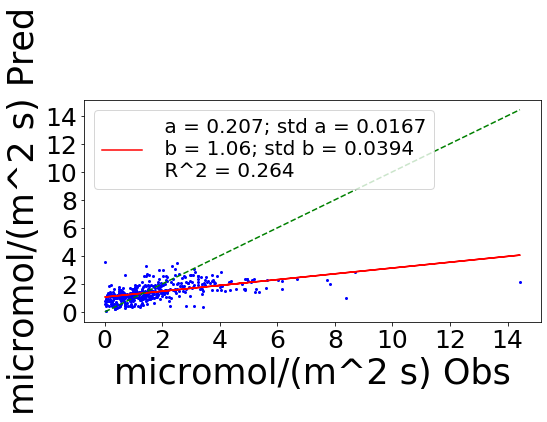

In [270]:
plt.figure(figsize=(18,9))
Xv = datos_validos.drop(datos_ordenados.index)
hola = identidad(lloyd_taylor, [14.36, 53.44], Xv['Tair'], Xv['NEE'], 'micromol/(m^2 s)', ['a', 'b'])